In [1]:
import pandas
import os
import itertools
import numpy as np
import nibabel as ni
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection, linear_model
from nilearn import image, plotting
from mpl_toolkits.mplot3d import Axes3D

//anaconda/envs/py3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Insert the git directory associated with these notebooks below, and import the scripts

In [44]:
# Your git directory here:
git_dir = '/home/users/jvogel/git/Hippocampus_AP_Axis/'

import sys
sys.path.insert(0,git_dir)
import HAP_Utils as hap

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Get hippocampus gene expression data (X)
Note: The spreadheets below are generated in N1, or in the case of "probes", are straight from the Allen Brain Atlas dataset

In [4]:
wdir = '/data1/users/jvogel/Allen_Human_Brain_Atlas/'
df = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_sample_info.csv'))
#df =  pandas.read_csv(os.path.join(wdir,'MAIN_ALLVAR_hippocampus_sample_info.csv'), index_col=0)
xp = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_gxp.csv'),index_col=0)
gdf = pandas.read_csv(os.path.join(wdir,'MAIN_gcx_wholebrain_info.csv'))
#gdf = pandas.read_csv(os.path.join(wdir,'MAIN_gcx_wholebrain_info_W_SMALL_SETS.csv'))
probes = pandas.read_csv(os.path.join(wdir,'normalized_microarray_donor9861/Probes.csv'))

In [2]:
# PERSONAL COMPUTER
wdir = '/Users/jakevogel/Science/AHBA/'
df = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_sample_info.csv'))
xp = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_gxp.csv'),index_col=0)
gdf = pandas.read_csv(os.path.join(wdir,'MAIN_gcx_wholebrain_info.csv'))
probes = pandas.read_csv('/Users/jakevogel/Downloads/normalized_microarray_donor9861/Probes.csv')

# Get location of samples along axis
Note: See xxx for script used to create the hippocapmus axis

Let's visualize the longitudinal axis of the hippocampus that we derived on a template brain

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


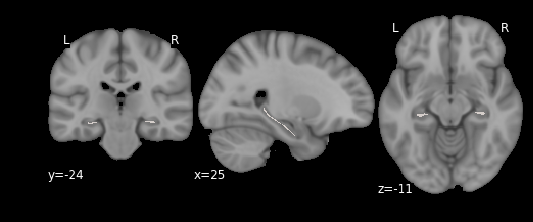

In [5]:
# VIEW HIPPOCAMPUS AXIS

#ap_axis = ni.load('/Users/jakevogel/Science/AHBA/blob_line_skel_1mm_2nii.nii')
ap_axis = ni.load('/data1/users/jvogel/Allen_Human_Brain_Atlas/axis/blob_line_skel_1mm_2nii.nii')
mni = ni.load('/home/users/jvogel/Science/templates/templates/MNI152_T1_1mm_brain.nii')
#mni = ni.load('/Users/jakevogel/Science/tau/MNI152_T1_1mm_brain.nii')
plt.close()
plotting.plot_roi(ap_axis, mni, draw_cross=False, cmap='Reds')
plt.show()

Here, we find the closest axis coordinate to each hippocampus sample

In [8]:
# Get the MNI coordinates of each sample and convert them to XYZ
sample_coords = []
for i,row in df.iterrows():
    sample_coords.append(hap.convert_coords([row['mni_nlin_x'], 
                                             row['mni_nlin_y'], 
                                             row['mni_nlin_z']], 
                                            'xyz'))

# Get the coordinates of each skeleton voxel
skel_coords = np.where(ap_axis.get_data() > 0)

# find the closest coordinates
y_location, closest_points = hap.find_closest_point_along_axis(sample_coords,skel_coords)

# store this data in the spreadsheet
df.loc[:,'position_along_hipp_AP_axis'] = y_location

# Get Binary information

In [3]:
bigB = pandas.read_csv('/Users/jakevogel/Science/AHBA/BIGDF_B.csv',index_col=0)

In [29]:
inds = []
for col in xp.columns:
    donor,no = col.split('_')
    inds.append(gdf[(gdf.donor==int(donor)) & (gdf['sample']==int(no))].index[0])

In [33]:
hipp_bin = bigB.iloc[:,inds]

In [38]:
xp.shape

(58692, 170)

In [39]:
scaled_xp = MinMaxScaler(copy=True).fit_transform(xp.T).T

In [52]:
cleaned_xp = pandas.DataFrame((scaled_xp * hipp_bin.values), 
                              index = xp.index, columns=xp.columns, copy=True)

In [55]:
cleaned_xp2 = pandas.DataFrame((xp.values * hipp_bin.values), 
                              index = xp.index, columns=xp.columns, copy=True)

# Run main LASSO-PCR analysis pipeline and evaluate

running PCA
transforming data
performing model cross-validation
using basic 10-fold cross-validation


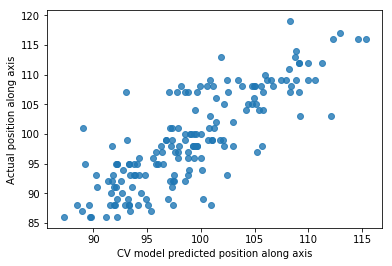

model cv score: r2 =  0.6758859774821814
running final model
final model fit r2 =  0.8768105093258005


//anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


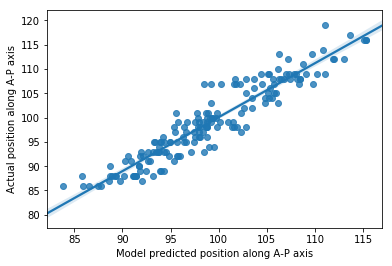

running sanity_check


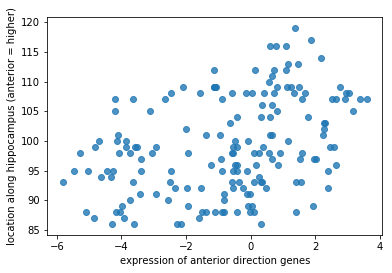

anterior 1 genes vs. y:  r2 = 0.14629196014520224, p = 2.643623001667436e-07 




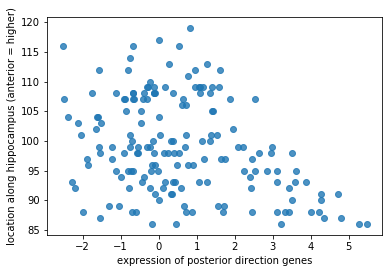

posterior 1 genes vs. y:  r2 = 0.12083902318757654, p = 3.406748231336911e-06 




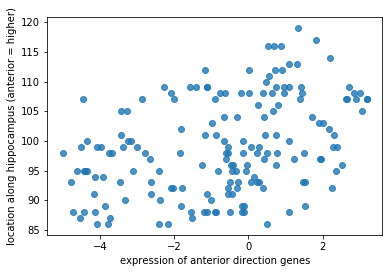

anterior 2 genes vs. y:  r2 = 0.15681046319903055, p = 9.033761155250064e-08 




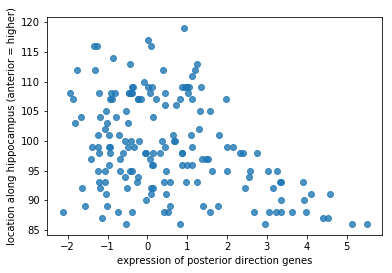

posterior 2 genes vs. y:  r2 = 0.14078245533337322, p = 4.619806057631215e-07 




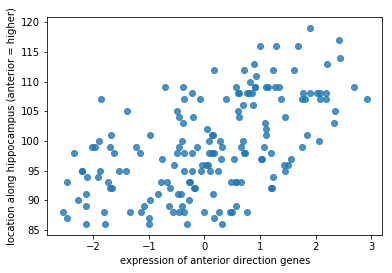

anterior 5 genes vs. y:  r2 = 0.3120276412846879, p = 2.4662826207105336e-15 




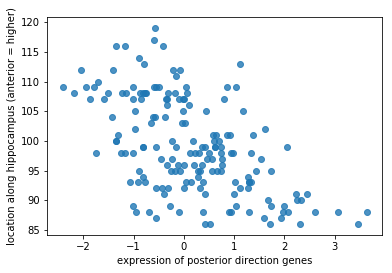

posterior 5 genes vs. y:  r2 = 0.3088720843951695, p = 3.640128882095161e-15 




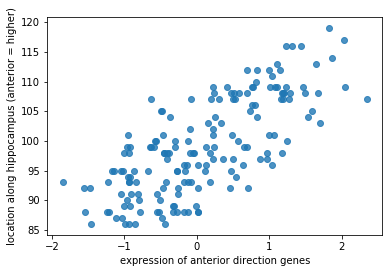

anterior 10 genes vs. y:  r2 = 0.5417433381516534, p = 2.8362558223402614e-30 




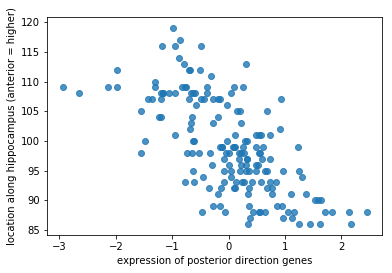

posterior 10 genes vs. y:  r2 = 0.45513306654039, p = 6.3820616343206416e-24 




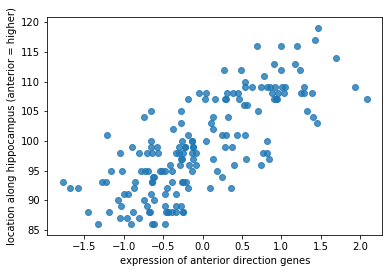

anterior 20 genes vs. y:  r2 = 0.5772779741942704, p = 3.123957404584345e-33 




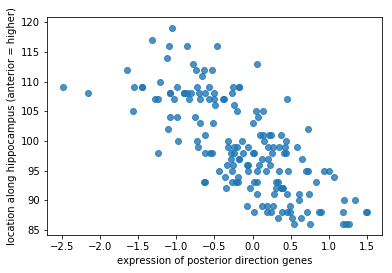

posterior 20 genes vs. y:  r2 = 0.5287595402930862, p = 3.0001152711919667e-29 




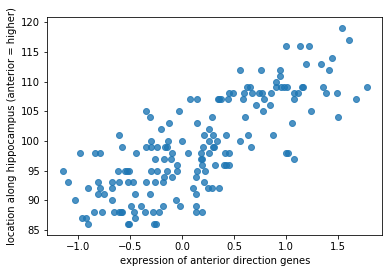

anterior 50 genes vs. y:  r2 = 0.6047815666383575, p = 1.072778633816526e-35 




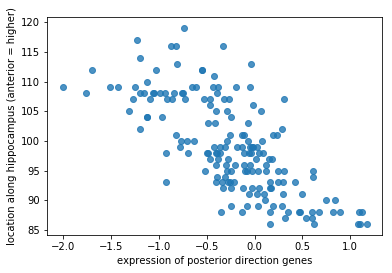

posterior 50 genes vs. y:  r2 = 0.5214958089955475, p = 1.091698561865245e-28 




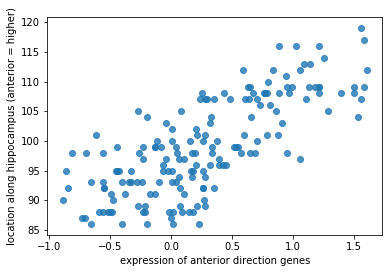

anterior 100 genes vs. y:  r2 = 0.5685353701955165, p = 1.7568686274802046e-32 




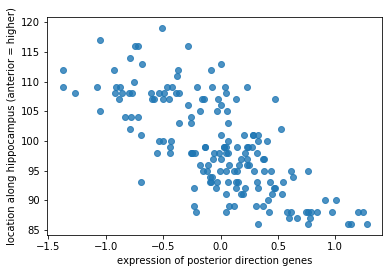

posterior 100 genes vs. y:  r2 = 0.5305694445470377, p = 2.167852996085666e-29 




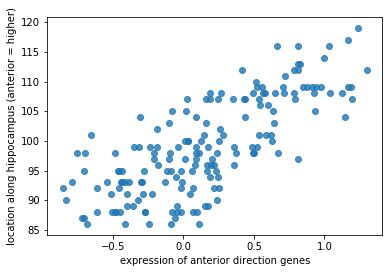

anterior 200 genes vs. y:  r2 = 0.5739899541952755, p = 6.005892221386507e-33 




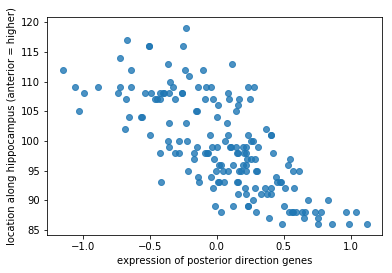

posterior 200 genes vs. y:  r2 = 0.5300127491687814, p = 2.3960150940034738e-29 




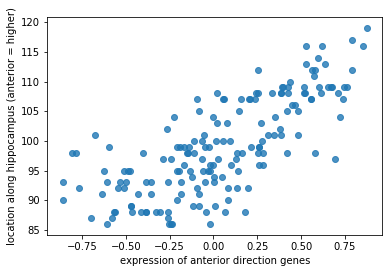

anterior 500 genes vs. y:  r2 = 0.561315373963959, p = 7.126299913099092e-32 




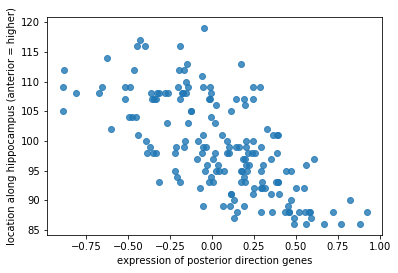

posterior 500 genes vs. y:  r2 = 0.4567010467132692, p = 5.001493967621759e-24 




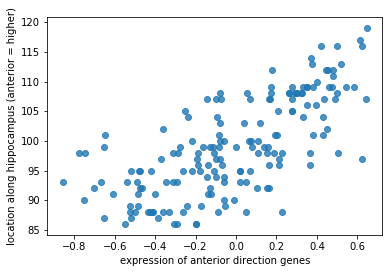

anterior 1000 genes vs. y:  r2 = 0.506219222540632, p = 1.5519698983995287e-27 




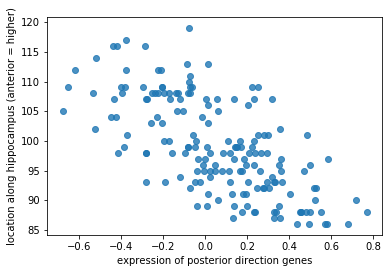

posterior 1000 genes vs. y:  r2 = 0.4544182935272975, p = 7.130482623735305e-24 




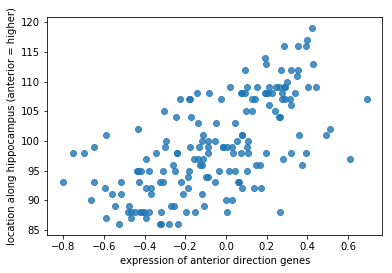

anterior 2000 genes vs. y:  r2 = 0.4135829007240299, p = 3.2074787398814058e-21 




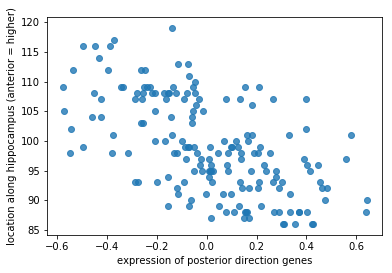

posterior 2000 genes vs. y:  r2 = 0.34865926180578455, p = 2.3587469013291807e-17 




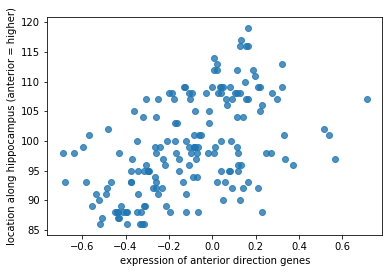

anterior 5000 genes vs. y:  r2 = 0.2602506835478756, p = 1.1941625384485097e-12 




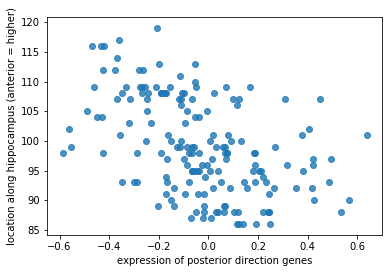

posterior 5000 genes vs. y:  r2 = 0.2270398562612534, p = 5.098941871190961e-11 




//anaconda/envs/py3/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


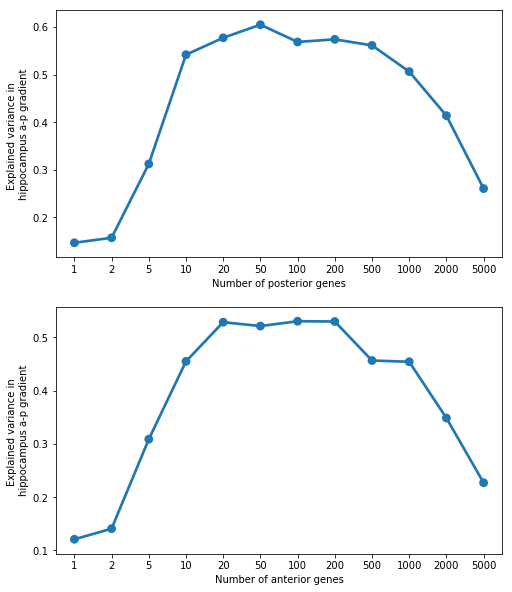

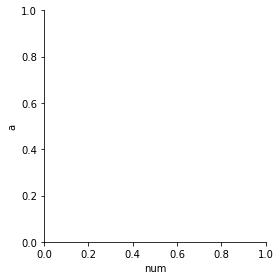

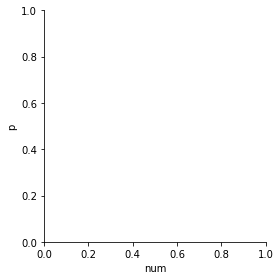

In [45]:
pcalr_out_NEW = hap.PCA_LR_pipeline(xp.values.T, # X (Gene expression)
                                    df.position_along_hipp_AP_axis, # Y (Location on axis)
                                    cv_strategy='score', # Show the 10-fold CV score
                                    illustrative=True, # Show plots
                                    test_gene_num = [1, 2, 5, 10, 20, 50, 100,  # sanity check
                                                    200, 500, 1000, 2000, 5000],
                                    sanity_check_style = 'separate') # post. and ant. separate

running PCA
transforming data
performing model cross-validation
using basic 10-fold cross-validation


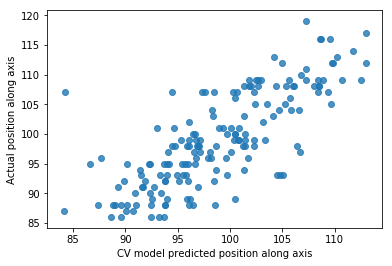

model cv score: r2 =  0.6077376484461101
running final model
final model fit r2 =  0.8482351111415108


//anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


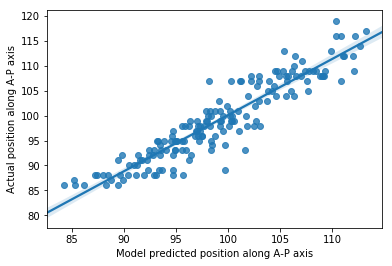

running sanity_check


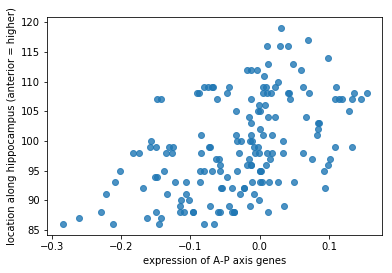

posterior and anterior 1 genes vs. y:  r2 = 0.2354252840903403, p = 2.0046988434524752e-11 




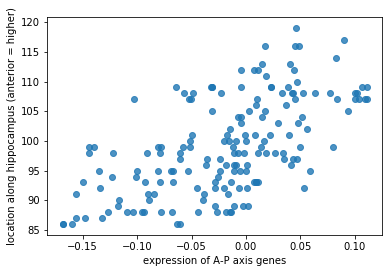

posterior and anterior 2 genes vs. y:  r2 = 0.3602644237336027, p = 5.127971530575679e-18 




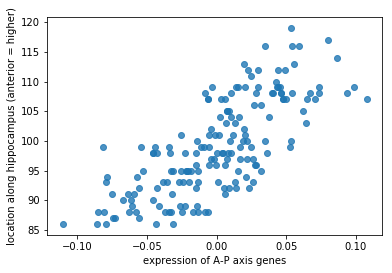

posterior and anterior 5 genes vs. y:  r2 = 0.5615424375614421, p = 6.821670199720584e-32 




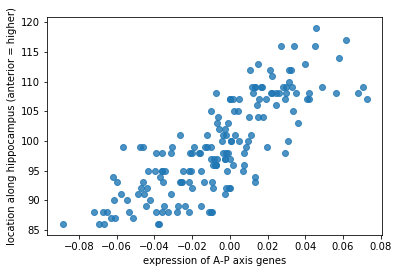

posterior and anterior 10 genes vs. y:  r2 = 0.6507177938872428, p = 3.2166575566607344e-40 




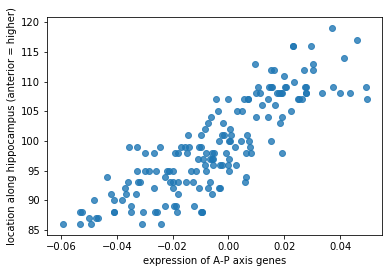

posterior and anterior 20 genes vs. y:  r2 = 0.7168740337479939, p = 6.702077017547712e-48 




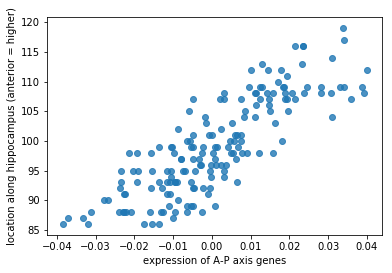

posterior and anterior 50 genes vs. y:  r2 = 0.6876402808391876, p = 2.6292239422334696e-44 




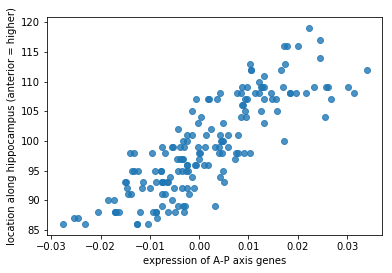

posterior and anterior 100 genes vs. y:  r2 = 0.702782626850604, p = 4.003011783195081e-46 




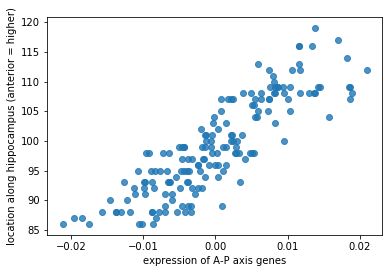

posterior and anterior 200 genes vs. y:  r2 = 0.7478997535097335, p = 3.828381508817549e-52 




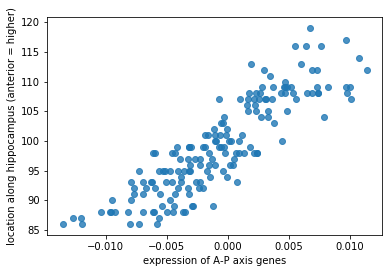

posterior and anterior 500 genes vs. y:  r2 = 0.7684894266596433, p = 2.9444466868502338e-55 




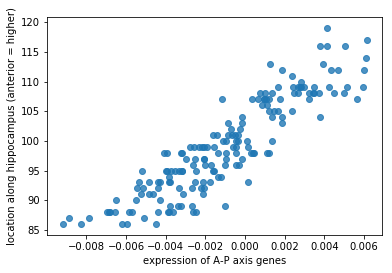

posterior and anterior 1000 genes vs. y:  r2 = 0.808046219019725, p = 4.196011027105007e-62 




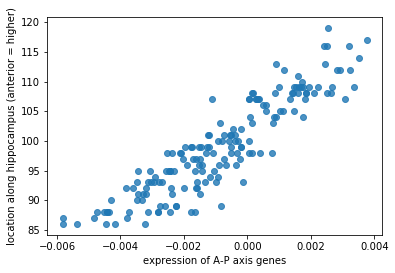

posterior and anterior 2000 genes vs. y:  r2 = 0.8257426161383833, p = 1.2295303650127105e-65 




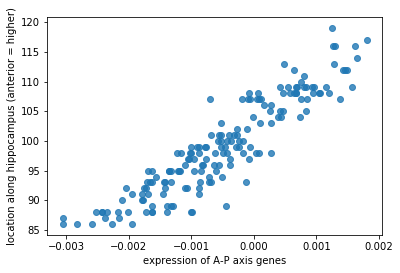

posterior and anterior 5000 genes vs. y:  r2 = 0.8439459933547642, p = 1.1484293363851876e-69 




//anaconda/envs/py3/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


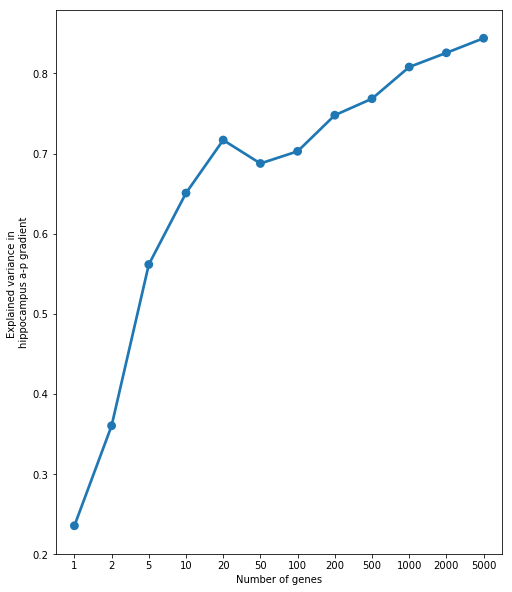

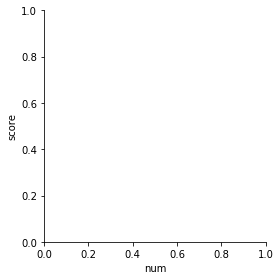

In [56]:
pcalr_out_NEW = hap.PCA_LR_pipeline(cleaned_xp2.values.T, # X (Gene expression)
                                    df.position_along_hipp_AP_axis, # Y (Location on axis)
                                    cv_strategy='score', # Show the 10-fold CV score
                                    illustrative=True, # Show plots
                                    test_gene_num = [1, 2, 5, 10, 20, 50, 100,  # sanity check
                                                    200, 500, 1000, 2000, 5000],
                                    sanity_check_style = 'model') # post. and ant. separate

#### Do ten rounds of 10-fold CV and plot

In [57]:
## Run 10-fold cross-validation 10 times

# Redoing snippets of the pipeline above
clf = linear_model.LassoCV(random_state = 123) # set LASSO model
pca_tfm = pcalr_out_NEW['pca_object'].transform(xp.values.T) # perform PCA
cv=10 # 10 rounds
cv_strategy=10 # 10 folds 
y = df.position_along_hipp_AP_axis

score = [] # capture score at each round (just out of interest)
preds = np.zeros((cv_strategy,len(y))) # empty matrix to save predictions

# Run it
for i in range(cv_strategy): # for each round
    # set KFold object
    sel = model_selection.KFold(n_splits=cv, shuffle=True, random_state=(123 * (i+1)))
    # Make predictions
    predicted = model_selection.cross_val_predict(clf, pca_tfm, y=y, cv=sel)
    # store predictions and scores
    preds[i,:] = predicted
    score.append(stats.pearsonr(predicted, y)[0]**2)
    print('completed iteration',i+1)

# print scores from each round
score

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You 

completed iteration 1


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


KeyboardInterrupt: 

#### PLOT THE RESULTS

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


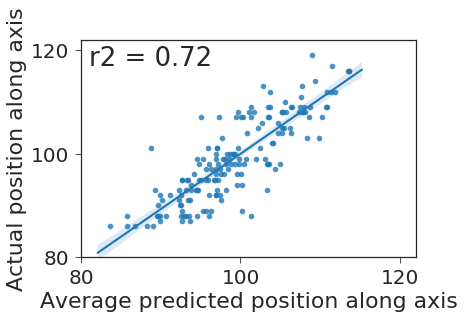

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


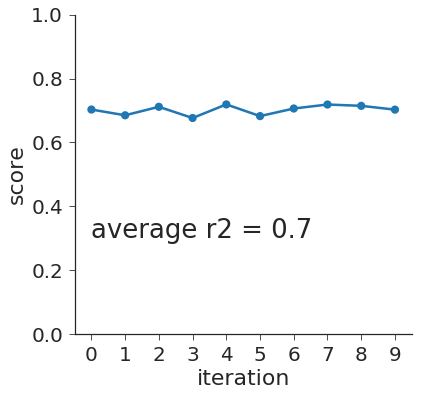

average r2: 0.7020045522491339
std r2: 0.015490045272715525


In [18]:
plt.close()
sns.set_context('paper', font_scale=2.5)
sns.set_style('ticks')
sns.regplot(preds.mean(0), y, fit_reg=True)
plt.xlim(80,122)
plt.ylim(80,122)
plt.xticks(range(80,121,20))
plt.yticks(range(80,121,20))
plt.xlabel('Average predicted position along axis')
plt.ylabel('Actual position along axis')
r2 = np.float16(stats.pearsonr(preds.mean(0), y)[0]**2)
plt.text(81, 117,'r2 = %s'%(float('%.2g' % r2)), fontsize=26)
#plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/model_cross_val_revised.pdf', 
 #           bbox_inches='tight')
plt.show()

jnk = pandas.DataFrame(index = range(cv_strategy), 
                       columns = ['score','iteration'])
jnk.loc[:,'iteration'] = list(range(cv_strategy))
jnk.loc[:,'score'] = score
plt.close()
sns.factorplot(x='iteration',y='score',data=jnk, size=6, aspect=1.1)
plt.yticks([0,0.2,0.4,0.6,0.8,1])
plt.text(0, 0.3,'average r2 = %s'%(float('%.2g' % np.mean(score))), fontsize=26)
plt.show()
print('average r2:',np.mean(score))
print('std r2:', np.std(score,ddof=1))
#plt.savefig('/Users/jakevogel/Dropbox/Work/Projects/AHBA_Hippocampus_AP/avg_cross_val.pdf', 
#            bbox_inches='tight')

### FIT THE MODEL TO THE WHOLE DATASET

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


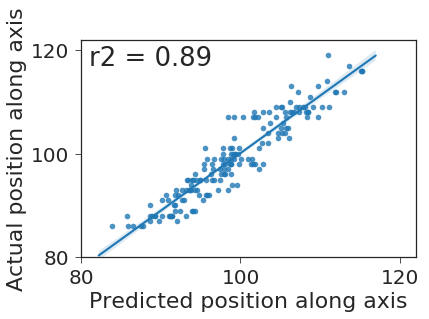

In [20]:
plt.close()
sns.regplot(pcalr_out_NEW['final_model'].predict(pca_tfm),y)
plt.xlim(80,122)
plt.ylim(80,122)
plt.xticks(range(80,121,20))
plt.yticks(range(80,121,20))
plt.xlabel('Predicted position along axis')
plt.ylabel('Actual position along axis')
r2 = np.float16(stats.pearsonr(pcalr_out_NEW['final_model'].predict(pca_tfm), y)[0]**2)
plt.text(81, 117,'r2 = %s'%(float('%.2g' % r2)), fontsize=26)
#plt.savefig('/Users/jakevogel/Dropbox/Work/Projects/AHBA_Hippocampus_AP/full_model_fit.pdf', 
#          bbox_inches='tight')
plt.show()

### LOOK AT DISTRIBUTION OF WEIGHTS

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


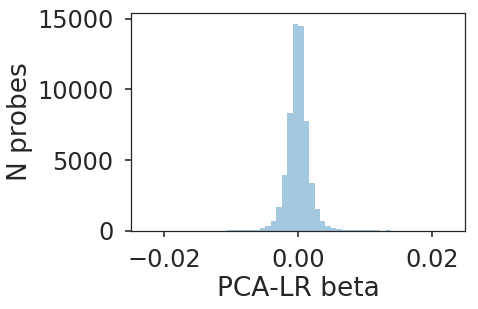

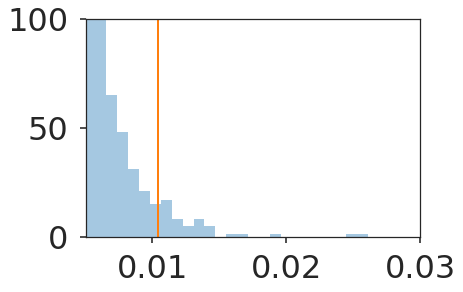

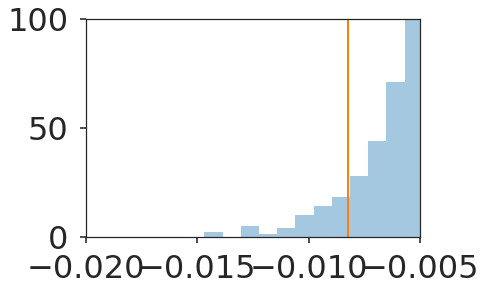

In [21]:


## WHOLE DISTRIBUTION
plt.close()
sns.set_context('poster',font_scale=1.5)
sns.distplot(pcalr_out_NEW['betas'],kde=False)
plt.xlim(-0.025,0.025)
plt.xlabel('PCA-LR beta')
plt.ylabel('N probes')
#plt.savefig('/Users/jakevogel/Dropbox/Work/Projects/AHBA_Hippocampus_AP/BetaDist.pdf',
#           bbox_inches = 'tight')
plt.show()

## ZOOM ON RIGHT SIDE
plt.close()
sns.set_context('poster',font_scale=2)
sns.distplot(pcalr_out_NEW['betas'],kde=False)
plt.xlim(0.005,0.030)
plt.ylim(0,100)
xval = sorted(pcalr_out_NEW['betas'])[-50]
plt.plot([xval, xval], [0, 100], linewidth=2)
#plt.savefig('/Users/jakevogel/Dropbox/Work/Projects/AHBA_Hippocampus_AP/BetaDistL.pdf',
#           bbox_inches='tight')
plt.show()

# ZOOM ON LEFT SIDE
plt.close()
sns.set_context('poster',font_scale=2)
sns.distplot(pcalr_out_NEW['betas'],kde=False)
plt.xlim(-0.02,-0.005)
plt.xticks([-0.02, -0.015, -0.01, -0.005])
plt.ylim(0,100)
xval = sorted(pcalr_out_NEW['betas'])[50]
plt.plot([xval, xval], [0, 100], linewidth=2)
#plt.savefig('/Users/jakevogel/Dropbox/Work/Projects/AHBA_Hippocampus_AP/BetaDistR.pdf',
#           bbox_inches='tight')
plt.show()

#### LOOK AT MODEL ACROSS SUBFIELDS (FIT TO ALL DATA)

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


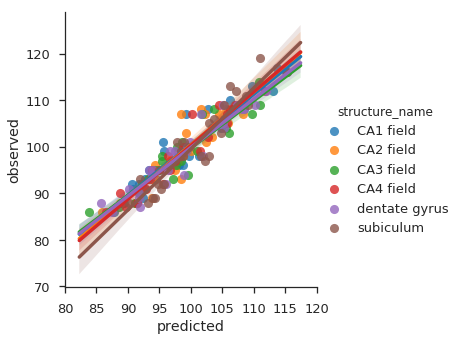

In [23]:
# we only care about structure, not hemisphere...
df.loc[:,'bilateral_structure_name'] = [x.split(',')[0] for x in df.structure_name.values]

sns.set_context('talk')
sns.set_style('ticks')
pca_tfm = pcalr_out_NEW['pca_object'].transform(xp.values.T) # transform with PCA
predicted = pcalr_out_NEW['final_model'].predict(pca_tfm) # get predicted values

# put in df with structure name
jnk = pandas.concat([pandas.Series(predicted),
                     df.position_along_hipp_AP_axis,
                    df.bilateral_structure_name], axis=1) 
jnk.columns = ['predicted','observed','structure_name']

# plot
plt.close()
sns.lmplot(x='predicted', y='observed', hue='structure_name', data=jnk)
plt.xticks(range(80,125,5))
plt.show()

#### LOOK AT MODEL ACROSS SUBFIELDS (FIT TO ALL DATA)

//anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


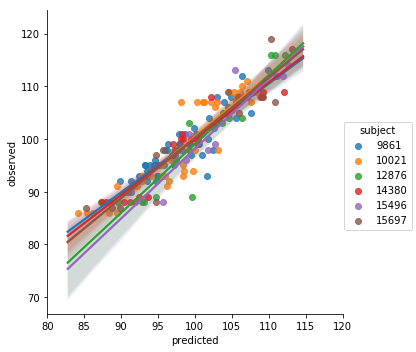

In [58]:
#pca_tfm = pcalr_out_NEW['pca_object'].transform(xp.values.T)
pca_tfm = pcalr_out_NEW['pca_object'].transform(cleaned_xp2.values.T)
predicted = pcalr_out_NEW['final_model'].predict(pca_tfm)

jnk = pandas.concat([pandas.Series(predicted),
                     df.position_along_hipp_AP_axis,
                     df['donor']], 
                    axis=1)
jnk.columns = ['predicted','observed','subject']

plt.close()
sns.lmplot(x='predicted', y='observed', hue='subject', data=jnk)
plt.xticks(range(80,125,5))
plt.show()

## Leave-one-subfield-out analysis
We train the model on five subfields and try to predict sample location of the sixth subfield.
We repeat for each subfield

//anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


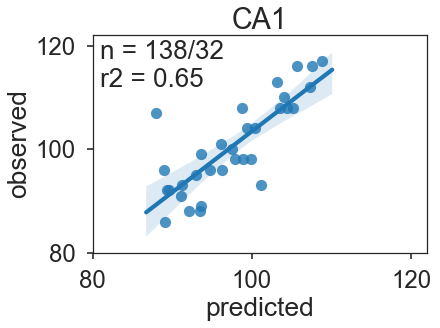

//anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


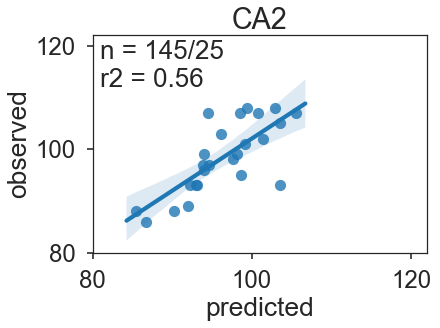

//anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


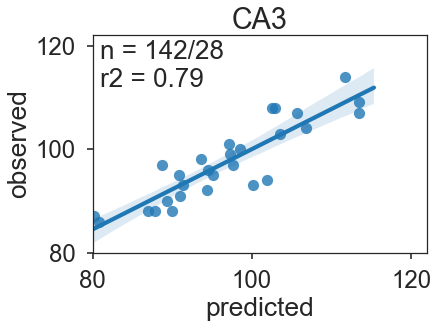

//anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


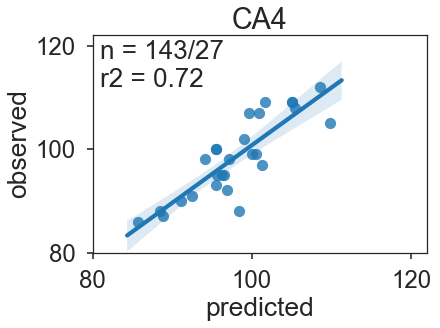

//anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


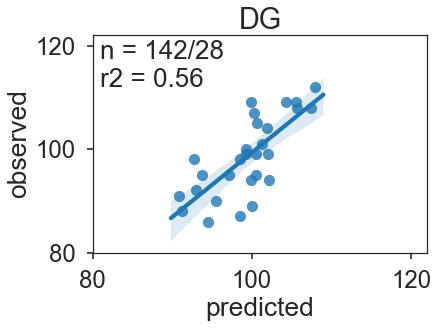

//anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


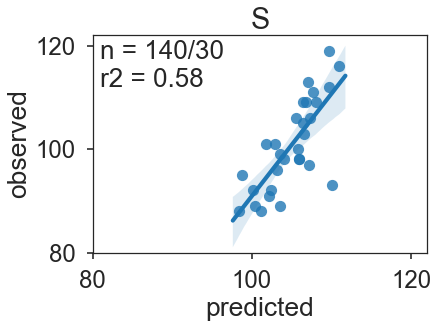

In [59]:
# set model
clf = linear_model.LassoCV(random_state = 123)

for i,subfield in enumerate(df.structure_acronym.unique()): # for each subfield
    # identify which hippocampal samples to train on (not the subfield)
    Tr_samps = df[df.structure_acronym!=subfield].index
    # identify which hippocampal samples to test on (the subfield)
    Te_samps = df[df.structure_acronym==subfield].index
    # size of train and test
    nX = len(Te_samps)
    nT = len(Tr_samps)
    # set X and Y 
    X = pca_tfm[Tr_samps,:]
    y = df.loc[Tr_samps,'position_along_hipp_AP_axis']
    # run model on training sample
    mod = clf.fit(X,y)
    # predict axis location for the left out subfield
    pred = mod.predict(pca_tfm[Te_samps,:])
    
    # Plot it
    plt.close()
    sns.set_context('poster', font_scale=1.5)
    sns.set_style('ticks')
    sns.regplot(pred, df.loc[Te_samps,'position_along_hipp_AP_axis'].values)
    plt.title(subfield)
    plt.xlim(80,122)
    plt.ylim(80,122)
    plt.xticks(range(80,121,20))
    plt.yticks(range(80,121,20))
    plt.xlabel('predicted')
    plt.ylabel('observed')
    # overlay r2
    r2 = np.float16(stats.pearsonr(pred, df.loc[Te_samps,'position_along_hipp_AP_axis'].values
                                  )[0]**2)
    # overlay sample sizes
    plt.text(81, 112,'n = %s/%s\nr2 = %s'%(nT,nX,float('%.2g' % r2)), fontsize=26)
    #plt.savefig('/Users/jakevogel/Dropbox/Work/Projects/AHBA_Hippocampus_AP/LOSO_%s.pdf'%subfield, 
    #            bbox_inches='tight')
    plt.show()

## Leave-one-donor-out analysis
We train the model on five donors and try to predict sample location of the sixth donor.
We repeat for each donor

//anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


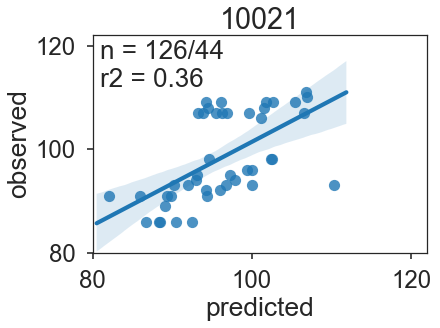

//anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


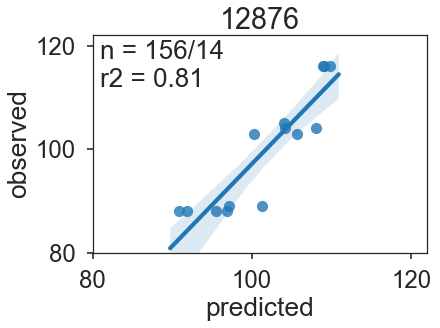

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


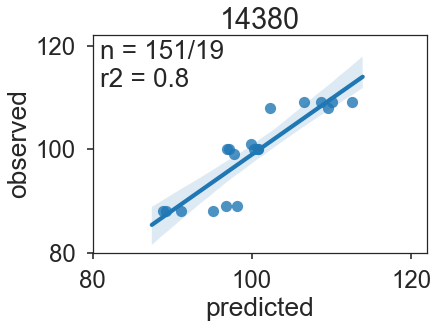

//anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


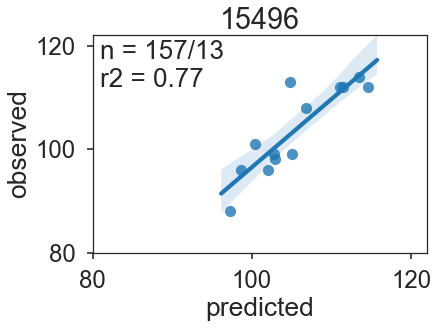

//anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


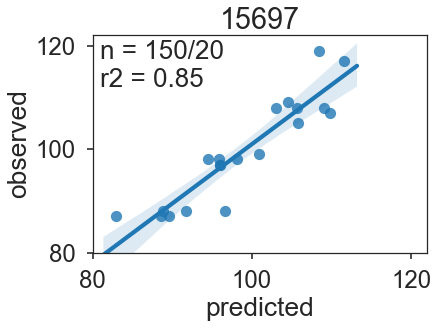

//anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


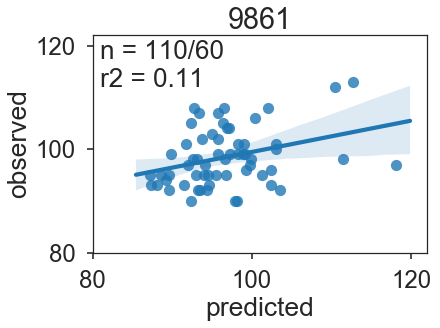

In [60]:
# initialize model
clf = linear_model.LassoCV(random_state = 123)

for i,subject in enumerate(df['donor'].unique()): # for each donor
    # ID samples from training sample (not the donor)
    Tr_samps =  df[df['donor']!=subject].index
    # ID samples from the test sample (the donor)
    Te_samps = df[df['donor']==subject].index
    # Set X and y
    X = pca_tfm[Tr_samps,:]
    y = df.loc[Tr_samps,'position_along_hipp_AP_axis']
    # get size of training and test
    nX = len(Te_samps)
    nT = len(Tr_samps)
    # run model
    mod = clf.fit(X,y)
    # predict axis location for samples from the left-out donor
    pred = mod.predict(pca_tfm[Te_samps,:])
    
    # plot it
    plt.close()
    sns.set_context('poster', font_scale=1.5)
    sns.set_style('ticks')
    sns.regplot(pred, df.loc[Te_samps,'position_along_hipp_AP_axis'].values)
    plt.title(subject)
    plt.xlim(80,122)
    plt.ylim(80,122)
    plt.xticks(range(80,121,20))
    plt.yticks(range(80,121,20))
    plt.xlabel('predicted')
    plt.ylabel('observed')
    # overlay r2
    r2 = np.float16(stats.pearsonr(pred, df.loc[Te_samps,'position_along_hipp_AP_axis'].values
                                  )[0]**2)
    # overlay sample sizes for train and test sets
    plt.text(81, 112,'n = %s/%s\nr2 = %s'%(nT,nX,float('%.2g' % r2)), fontsize=26)
    #plt.savefig('/Users/jakevogel/Dropbox/Work/Projects/AHBA_Hippocampus_AP/LOSubO_%s.pdf'%subject, 
    #            bbox_inches='tight')
    plt.show()

#### Leave-one-hemisphere-out
A co-author asked for this. I don't think it makes that much sense to do, but I keep it here in case a reviewer asks for it... 

//anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


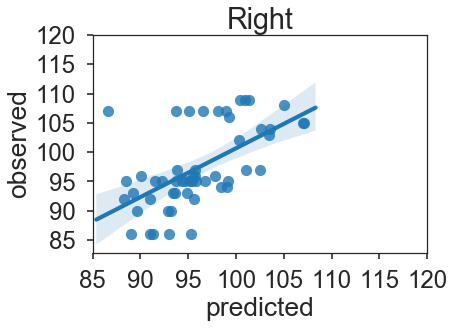

0.3486


//anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


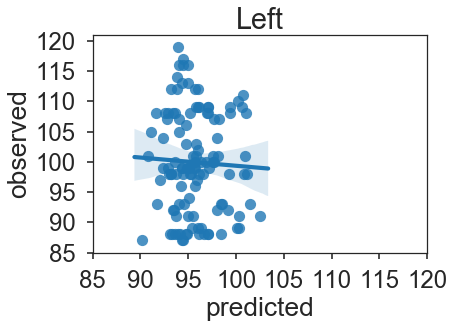

0.001696


In [61]:
hemi = ['Left' if x < 0 else 'Right' for x in df.mni_nlin_x]
df.loc[:,'hemisphere'] = hemi
for hemisphere in df['hemisphere'].unique():
    Tr_samps =  df[df['hemisphere']!=hemisphere].index
    Te_samps = df[df['hemisphere']==hemisphere].index
    X = pca_tfm[Tr_samps,:]
    y = df.loc[Tr_samps,'position_along_hipp_AP_axis']
    mod = clf.fit(X,y)
    pred = mod.predict(pca_tfm[Te_samps,:])
    
    plt.close()
    sns.regplot(pred, df.loc[Te_samps,'position_along_hipp_AP_axis'].values)
    plt.title(hemisphere)
    plt.xticks(range(85,125,5))
    plt.yticks(range(85,125,5))
    plt.xlabel('predicted')
    plt.ylabel('observed')
    plt.show()
    print(np.float16(stats.pearsonr(pred, df.loc[Te_samps,'position_along_hipp_AP_axis'].values)[0]**2))

### TAKING A QUICK LOOK AT THE MOST IMPORTANT ANTERIOR AND POSTERIOR PROBES (ACCORDING TO THE LASSO-PCR MODEL)

In [62]:
probes.loc[pcalr_out_NEW['gene_selections']['anterior_genes_50']]['gene_symbol'].tolist()

['SERPINF1',
 'SERPINF1',
 'KLK7',
 'KLK7',
 'LYPD1',
 'SYTL2',
 'KCNG1',
 'AQP3',
 'SSTR1',
 'LMO1',
 'NR2F2',
 'RSPH9',
 'LXN',
 'NR2F2',
 'NR2F2',
 'RSPO2',
 'HTR3A',
 'GPR83',
 'GHSR',
 'PTGES',
 'NRG1',
 'C20orf103',
 'C1QL1',
 'GABRQ',
 'FAM148C',
 'GPR83',
 'PCOLCE2',
 'LXN',
 'C20orf103',
 'GPR26',
 'C20orf103',
 'BAIAP3',
 'OBFC2A',
 'IGFBP5',
 'GPR26',
 'RP13-102H20.1',
 'DNAH12',
 'PDYN',
 'SYTL2',
 'LOC100129291',
 'CD36',
 'PCOLCE2',
 'PLAC2',
 'GDA',
 'SYTL2',
 'RASL10A',
 'PDYN',
 'PDYN',
 'FAM150B',
 'CLEC4G']

In [63]:
probes.loc[pcalr_out_NEW['gene_selections']['posterior_genes_50']]['gene_symbol'].tolist()[::-1]

['NPNT',
 'A_32_P11262',
 'TTR',
 'HHIP',
 'NPNT',
 'HHIP',
 'RP11-291L15.2',
 'TTR',
 'CHRNA1',
 'GNG4',
 'WNT10A',
 'PDLIM5',
 'A_24_P401842',
 'NTN1',
 'FAM43B',
 'CARTPT',
 'PDCD6',
 'CARTPT',
 'PDLIM5',
 'NCALD',
 'KLK1',
 'CARTPT',
 'RGMA',
 'COL5A2',
 'NTS',
 'PVALB',
 'CARTPT',
 'PTX3',
 'GRHL2',
 'FSTL4',
 'EFHD2',
 'COL5A2',
 'FSTL4',
 'A_24_P102119',
 'DOK7',
 'CARTPT',
 'SCGN',
 'CASR',
 'HR',
 'PTTG3',
 'TUBA1C',
 'BNC2',
 'A_32_P168561',
 'CARTPT',
 'HTR2C',
 'ENO3',
 'THBD',
 'EPS8L1',
 'DGKH',
 'RERG']

### Make tables for the top genes

In [29]:
# MAKE TABLE FOR OVERLEAF
p50 = probes.loc[pcalr_out_NEW['gene_selections']['posterior_genes_50']][['probe_id',
                                                                    'gene_symbol',
                                                                   'gene_name']]
p50.loc[:,'beta'] = sorted(pcalr_out_NEW['betas'])[:50][::-1]
a50 = probes.loc[pcalr_out_NEW['gene_selections']['anterior_genes_50']][['probe_id',
                                                                    'gene_symbol',
                                                                   'gene_name']]
a50.loc[:,'beta'] = sorted(pcalr_out_NEW['betas'])[-50:][::-1]
gene_table = pandas.concat([a50,p50])
#gene_table

In [34]:
for i,ind in enumerate(gene_table.index[:50]):
    if pandas.notnull(g.loc[g.index[i],'Orig_A']):
        nname = probes[probes.gene_symbol==g.loc[i,'Ant']]['gene_name'].values
        if len(nname)>0:
            gene_table.loc[ind,'gene_symbol'] = g.loc[i,'Ant']
            gene_table.loc[ind,'gene_name'] = nname[0]
for i,ind in enumerate(gene_table.sort_values('beta',ascending=True).index[:50]):
    if pandas.notnull(g.loc[g.index[i],'Orig_P']):
        nname = probes[probes.gene_symbol==g.loc[i,'Post']]['gene_name'].values
        if len(nname)>0:
            gene_table.loc[ind,'gene_symbol'] = g.loc[i,'Post']
            gene_table.loc[ind,'gene_name'] = nname[0]

In [35]:
gene_table.head(10)

,probe_id,gene_symbol,gene_name,beta
4418,1053204,SERPINF1,"serpin peptidase inhibitor, clade F (alpha-2 a...",0.026119
4417,1053205,SERPINF1,"serpin peptidase inhibitor, clade F (alpha-2 a...",0.025298
25772,1030761,KLK7,kallikrein-related peptidase 7,0.019348
23274,1033144,RSPH9,radial spoke head 9 homolog (Chlamydomonas),0.016976
25771,1030762,KLK7,kallikrein-related peptidase 7,0.016178
20529,1036045,LYPD1,LY6/PLAUR domain containing 1,0.014526
15471,1041466,GABRQ,"gamma-aminobutyric acid (GABA) A receptor, theta",0.014374
24685,1032692,PYDC1,PYD (pyrin domain) containing 1,0.014255
14245,1042620,SYTL2,synaptotagmin-like 2,0.013917
22478,1034086,RP13-102H20.1,Rho GTPase activating protein 36,0.013885


In [36]:
gene_table.sort_values('beta').head()

,probe_id,gene_symbol,gene_name,beta
32889,1023030,NPNT,nephronectin,-0.014675
32888,1023031,NPNT,nephronectin,-0.014107
6582,1050553,TTR,transthyretin,-0.012919
51664,1064147,HHIP,hedgehog interacting protein,-0.012902
44200,1058844,BDKRB1,bradykinin receptor B1,-0.012402


In [1040]:
#a50.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/A50.csv')
#p50.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/P50.csv')

In [38]:
a50 = a50.sort_values('beta',ascending=False)
p50 = p50.sort_values('beta',ascending=True)
cols = ['probe_id','gene_symbol','beta']
for i,row in a50.sort_values('beta', ascending=False)[cols].iterrows():
    line = '\\makecell{%s} '%row[0]
    for item in row[1:]:
        line += '& \makecell{%s} '%item
    line += "\\\\"
    print(line)

\makecell{1053204} & \makecell{SERPINF1} & \makecell{0.0261188529546907} \\
\makecell{1053205} & \makecell{SERPINF1} & \makecell{0.025298202952924495} \\
\makecell{1030761} & \makecell{KLK7} & \makecell{0.01934808222290552} \\
\makecell{1033144} & \makecell{RSPH9} & \makecell{0.016975918576981004} \\
\makecell{1030762} & \makecell{KLK7} & \makecell{0.01617812672672332} \\
\makecell{1036045} & \makecell{LYPD1} & \makecell{0.01452624067016872} \\
\makecell{1041466} & \makecell{GABRQ} & \makecell{0.014374464105786827} \\
\makecell{1032692} & \makecell{PYDC1} & \makecell{0.01425489334370885} \\
\makecell{1042620} & \makecell{SYTL2} & \makecell{0.013917051360702207} \\
\makecell{1034086} & \makecell{RP13-102H20.1} & \makecell{0.013885223640234715} \\
\makecell{1042619} & \makecell{SYTL2} & \makecell{0.01366733725632215} \\
\makecell{1051105} & \makecell{SSTR1} & \makecell{0.013476517763340728} \\
\makecell{1041090} & \makecell{LXN} & \makecell{0.013430183075363956} \\
\makecell{1031172} & \

<input>:7: DeprecationWarning: invalid escape sequence \m
<input>:7: DeprecationWarning: invalid escape sequence \m
<input>:7: DeprecationWarning: invalid escape sequence \m
<ipython-input-38-c5d2ca9ff358>:7: DeprecationWarning: invalid escape sequence \m
  line += '& \makecell{%s} '%item


### Averaging the top 50 anterior and posterior genes... (sanity check)
The model produced a weight for each probe. To ensure these weights are actually proportional to importance, we identfigy the fifty probes with the highest and lowest weights, then average their raw signal, and ensure that the signal of these "important" probes is still associated with our phenotype.

Top 50 anterior probes

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


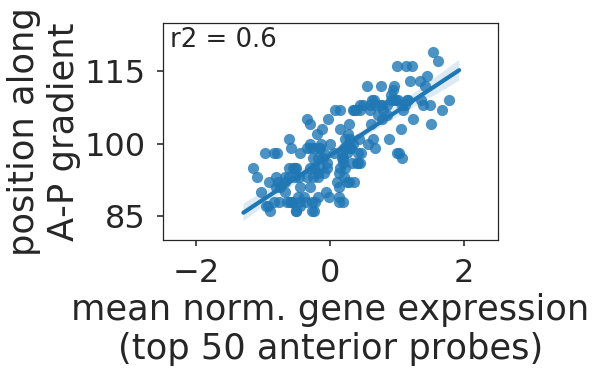

In [39]:
plt.close()
sns.set_context('poster',font_scale=2)
r2 = stats.pearsonr(xp.loc[pcalr_out_NEW['gene_selections']['anterior_genes_50']].mean(),
                    df.position_along_hipp_AP_axis)[0]**2
sns.regplot(xp.loc[pcalr_out_NEW['gene_selections']['anterior_genes_50']].mean(),
            df.position_along_hipp_AP_axis)
plt.xlabel('mean norm. gene expression\n(top 50 anterior probes)')
plt.ylabel('position along\nA-P gradient')
plt.xlim(-2.5,2.5)
plt.xticks([-2,0,2])
plt.ylim(80,125)
plt.yticks([85,100,115])
plt.text(-2.4, 120,'r2 = %s'%float('%.2g'%r2), fontsize=26)
#plt.savefig('/Users/jakevogel/Dropbox/Work/Projects/AHBA_Hippocampus_AP/ant50_position.pdf',
#           bbox_inches='tight')
plt.show()

Top 50 posterior probes

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


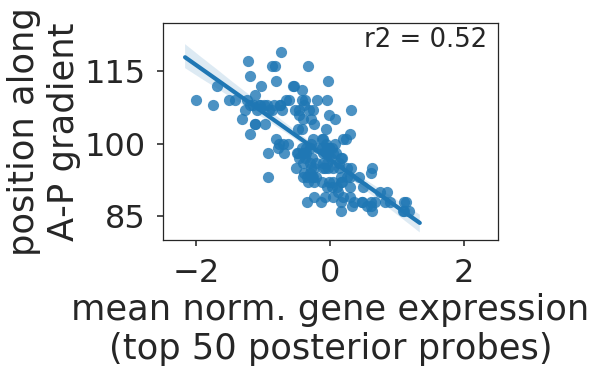

In [40]:
plt.close()
r2 = stats.pearsonr(xp.loc[pcalr_out_NEW['gene_selections']['posterior_genes_50']].mean(),
                    df.position_along_hipp_AP_axis)[0]**2
sns.regplot(xp.loc[pcalr_out_NEW['gene_selections']['posterior_genes_50']].mean(),
            df.position_along_hipp_AP_axis)
plt.xlabel('mean norm. gene expression\n(top 50 posterior probes)')
plt.ylabel('position along\nA-P gradient')
plt.xlim(-2.5,2.5)
plt.xticks([-2,0,2])
plt.ylim(80,125)
plt.yticks([85,100,115])
plt.text(0.5, 120,'r2 = %s'%float('%.2g'%r2), fontsize=26)
#plt.savefig('/Users/jakevogel/Dropbox/Work/Projects/AHBA_Hippocampus_AP/post50_position.pdf',
#           bbox_inches='tight')
plt.show()

# Absolute vs. Relative expression
See whether binarized gene expression information can explain the effects

In [41]:
# GET ALL BINARIZED GENE EXPRESSION DATA AT ONCE (This can take some time and requires a lot of memory)

shtz = sorted(glob(os.path.join(wdir,'normalized_microarray_donor*/PACall.csv')))
holder = []
for sht in shtz:
    jnk = pandas.read_csv(sht,header=None)
    jnk.drop(jnk.columns[0],axis=1,inplace=True)
    holder.append(jnk)
bigdf_b = pandas.concat(holder,axis=1)
del(holder)

In [42]:
## PULL OUT HIPPOCAMPUS SAMPLES
hipp_samps = []
for col in xp.columns:
    jnk = col.split('_')
    sub = jnk[0]
    samp = jnk[-1]
    idx = gdf[(gdf.donor==int(sub)) & (gdf['sample']==int(samp))].index
    hipp_samps.append(idx[0])
#hipp_samps = list(np.array(hipp_samps) + 1)

In [43]:
bin_hipp = bigdf_b.iloc[:,hipp_samps]
bin_hipp.shape

(58692, 170)

In [50]:
del(bigdf_b)

In [44]:
bin_hipp_a = bin_hipp.loc[pcalr_out_NEW['gene_selections']['anterior_genes_50']]
bin_hipp_p = bin_hipp.loc[pcalr_out_NEW['gene_selections']['posterior_genes_50']]

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


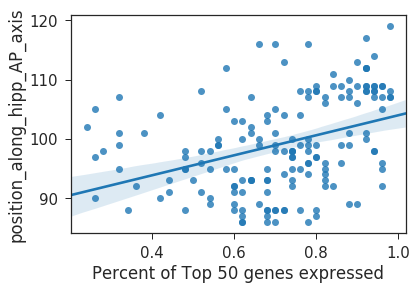

In [48]:
sns.set_context('notebook', font_scale=1.5)
plt.close()
sns.regplot(bin_hipp_a.mean(),df.position_along_hipp_AP_axis)
plt.xlabel('Percent of Top 50 genes expressed')
plt.show()

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


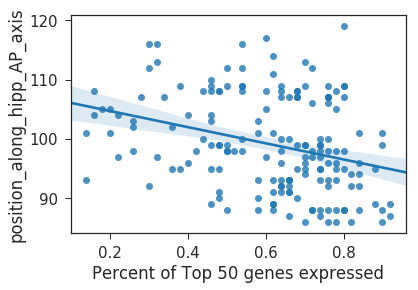

In [49]:
plt.close()
sns.regplot(bin_hipp_p.mean(),df.position_along_hipp_AP_axis)
plt.xlabel('Percent of Top 50 genes expressed')
plt.show()


# RENDER THE RESULTS ONTO THE HIPPOCAMPUS SURFACE

Get the hippocampus from the harvard-oxford atlas and view it

In [10]:
# load atlas
#jnk = ni.load('/usr/local/fsl/data/atlases/HarvardOxford/HarvardOxford-sub-maxprob-thr25-1mm.nii.gz')
jnk = ni.load('/usr/share/fsl/5.0/data/atlases/HarvardOxford/HarvardOxford-sub-maxprob-thr25-1mm.nii.gz')
atlas = jnk.get_data()
aff = jnk.affine

In [11]:
# Isolate hippocampus
hipp = np.zeros_like(atlas)
hipp[(atlas==9) | (atlas==19)] = 1
nhipp = ni.Nifti1Image(hipp, aff)

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


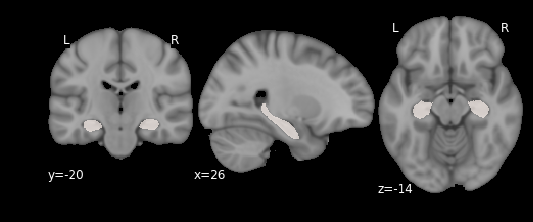

In [12]:
# Load MNI template
#mni = ni.load('/Users/jakevogel/Science/tau/MNI152_T1_1mm_brain.nii')
mni = ni.load('/home/users/jvogel/Science/templates/templates/MNI152_T1_1mm_brain.nii')

# plot hippocampus
plt.close()
plotting.plot_roi(nhipp, mni, draw_cross=False, cmap='Reds')
plt.show()

Identify closest tissue sample to each hippocampal voxel

In [13]:
hipp = nhipp.get_data()
hcoods = np.where(hipp==1)

In [57]:
# convert sample MNI coordinates to XYZ coordinates
s_coords = [hap.convert_coords([round(df.mni_nlin_x[x]),
                 round(df.mni_nlin_y[x]), 
                round(df.mni_nlin_z[x])],'xyz') for x in range(df.shape[0])]

In [58]:
# Make empty dataframe
vox = pandas.DataFrame(index=range(len(hcoods[0])),
                       columns=['x','y','z','ind'])

# for each coordinate in the hippocampus
for c in range(len(hcoods[0])):
    # get coordinate
    cord = [hcoods[0][c], hcoods[1][c], hcoods[2][c]]
    # find distance of each tissue sample to coordinate
    dists = [abs(cord[0] - s_coords[x][0]) + \
             abs(cord[1] - s_coords[x][1]) + \
             abs(cord[2] - s_coords[x][2]) for x in range(len(s_coords))]
    vox.loc[c, ['x','y','z']] = cord
    # store tissue sample with shortest distance to voxel
    vox.loc[c,'ind'] = np.argmin(dists)
    if c%1000 == 0:
        print('finished',c)

finished 0
finished 1000
finished 2000
finished 3000
finished 4000
finished 5000
finished 6000
finished 7000
finished 8000
finished 9000
finished 10000
finished 11000


In [85]:
#vox.to_csv(os.path.join(wdir,'MAIN_vox_mapping.csv'),index=False)

In [5]:
#vox = pandas.read_csv(os.path.join(wdir,'MAIN_vox_mapping.csv')).astype(int)

Plot

In [8]:
# Initiate X and y
mod = pcalr_out_NEW['final_model']
X = pcalr_out_NEW['pca_object'].transform(xp.T)
figy = mod.predict(X)


In [14]:
# For each hippocampus voxel,
# fill in predicted value of closest tissue sample
rend_hipp_T = np.zeros_like(hipp)
for i,row in vox.iterrows():
    rend_hipp_T[row['x'],row['y'],row['z']] = figy[row['ind']]

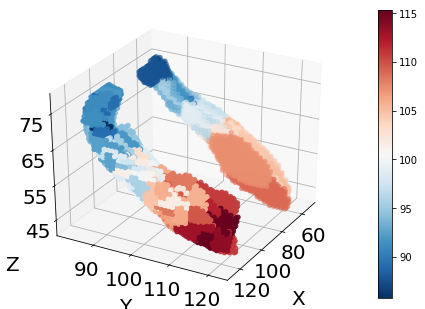

In [21]:
# plotit
hap.plot_3d_render(np.where(hipp == 1), rend_hipp_T)

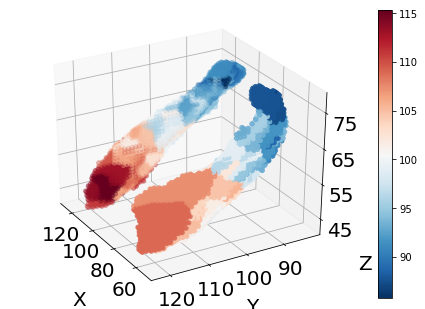

In [25]:
hap.plot_3d_render(np.where(hipp == 1), rend_hipp_T, r1=0, r2=180, step=30)

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


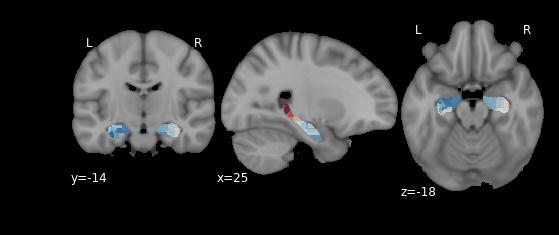

In [63]:
#mni = ni.load('/Users/jakevogel/Science/tau/MNI152_T1_1mm_brain.nii')
plt.close()
plotting.plot_roi(ni.Nifti1Image(rend_hipp_T, aff), mni, draw_cross=False, cmap='RdBu')
plt.show()

We repeat this process, but this time, we first move all tissue samples to the surface by first identifying the closest hippocampus surface voxel to each hippocampus voxel

In [5]:
# First, ID whether a voxel is a surface voxel 
# by seeing if it borders a zero
for c in range(len(hcoods[0])):
    cord = [hcoods[0][c], hcoods[1][c], hcoods[2][c]]
    if any(hipp[hap.make_cube(cord,2)]==0):
        vox.loc[c,'surface'] = 1
    else:
        vox.loc[c,'surface'] = 0
    if c%1000 == 0:
        print('finished',c)

In [27]:
surf_vox = pandas.DataFrame(vox[vox.surface==1],copy=True)

In [30]:
# Next, for each tissue sample, 
# find the index of the closest surface voxel

sample_surf_ind = []
arr = surf_vox[['x','y','z']].values
for i,row in df.iterrows():
    cord = hap.convert_coords([row['mni_nlin_x'],row['mni_nlin_y'],row['mni_nlin_z']],'xyz')
    dists = [abs(cord[0] - arr[x,0]) + \
             abs(cord[1] -  arr[x,1]) + \
             abs(cord[2] -  arr[x,2]) for x in range(surf_vox.shape[0])]
    sample_surf_ind.append(np.argmin(dists))
    if i%10 == 0:
        print('finished',i)

finished 0
finished 10
finished 20
finished 30
finished 40
finished 50
finished 60
finished 70
finished 80
finished 90
finished 100
finished 110
finished 120
finished 130
finished 140
finished 150
finished 160


In [31]:
df.loc[:,'surface_coordinate_index'] = sample_surf_ind

In [32]:
surf_vox = surf_vox.astype(int)

In [33]:
# rend_hipp_t2 = np.zeros_like(hipp)
# for i,row in surf_vox.iloc[sample_surf_ind].iterrows():
#     rend_hipp_t2[row['x'],row['y'],row['z']] = figy[row['ind']]

In [35]:
# Finally, for each voxel, find the closest surface voxel
s_coords = np.where(hipp == 1)
for i,row in surf_vox.iterrows():
    cord = [row['x'],row['y'],row['z']]
    dists = [abs(cord[0] - s_coords[0][x]) + \
             abs(cord[1] - s_coords[1][x]) + \
             abs(cord[2] - s_coords[2][x]) for x in range(len(s_coords[0]))]
    surf_vox.loc[i,'closest_surface_ind'] = np.argmin(dists)
    if i%1000 == 0:
        print('finished',i)

finished 0
finished 2000
finished 3000
finished 4000
finished 6000
finished 7000
finished 8000
finished 9000
finished 11000


In [37]:
# For each hippocampus voxel, fill in the closest surface voxel 
# with the predicted value of closest tissue sample
surf_vox = surf_vox.astype(int)
rend_hipp_t3 = np.zeros_like(hipp)
for i,row in surf_vox.iterrows():
    rend_hipp_t3[row['x'],row['y'],row['z']] = figy[row['ind']]

/home/users/jvogel/git/Hippocampus_AP_Axis/HAP_Utils.py:141: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  f = ax.scatter(label_locations[0], label_locations[1], label_locations[2], c = data[label_locations],


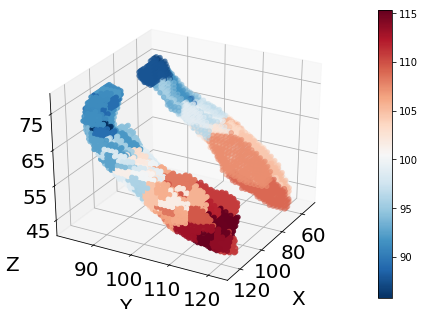

In [42]:
# Plot (here we get a bit more definition)
label_locations = [surf_vox['x'].tolist(),
                   surf_vox['y'].tolist(),
                   surf_vox['z'].tolist()] 
hap.plot_3d_render(label_locations, rend_hipp_t3)

/home/users/jvogel/git/Hippocampus_AP_Axis/HAP_Utils.py:141: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  f = ax.scatter(label_locations[0], label_locations[1], label_locations[2], c = data[label_locations],


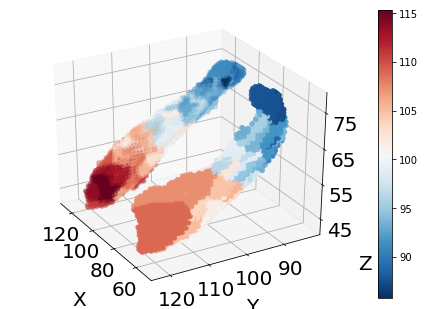

In [43]:
hap.plot_3d_render(label_locations, rend_hipp_t3, r1=0, r2=180, step=30)

# FITTING A PCR MODEL FOR COMPARISON
To ensure our results aren't totally unique to our model choice, we employ a similar model (Partial Least Squares)

In [65]:
# Load the module and some home-made PLS utilities
from sklearn.cross_decomposition import PLSRegression
sys.path.insert(0,'/home/users/jvogel/git/data_driven_pathology/')
import CrossDecomp as pls

ImportError: No module named 'CrossDecomp'

Use 10-fold CV to find the optimal number of components ("modes)

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score, mean_absolute_error

# create an empty dataframe
ncs = 20
nc_chooser = pandas.DataFrame(index = range(ncs), 
                              columns = ['nc','r2','mae'])
i=0

# From number of components 1-20,
for k,nc in enumerate(range(1,ncs+1)):
    print(nc)
    # Run a PLS model on the data with 10-fold CV
    #pred = cross_val_predict(PLSRegression(n_components=k+1), xp.T,
    pred = cross_val_predict(PLSRegression(n_components=k+1), cleaned_xp2.T,
                             df.position_along_hipp_AP_axis, 
                            groups = df.structure_acronym, cv=10)
    # Store the r2 
    nc_chooser.loc[i, 'r2'] = r2_score(y_true=df.position_along_hipp_AP_axis, y_pred=pred)
    nc_chooser.loc[i, 'mae'] = mean_absolute_error(y_true=df.position_along_hipp_AP_axis, y_pred=pred)
    nc_chooser.loc[i, 'estimator'] = 'PLS'
    i+=1

1
2
3
4


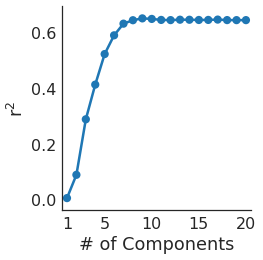

In [1006]:
# Plot learning curve
sns.set_context('paper', font_scale=2)
nc_chooser.loc[:,'nc'] = range(1,21)
plt.close()
g = sns.factorplot(x='nc', y='r2', data=nc_chooser, aspect=1)
g.set_xticklabels(['' if x not in [1,5,10,15,20] else x for x in range(1,21)])
plt.xlabel('# of Components')
plt.ylabel('r$^2$')
#plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/PLS_CV.pdf', 
#            bbox_inches='tight')
plt.show()


9 components seems best. Throw it into the model pipeline

performing model cross-validation
using basic 10-fold cross-validation


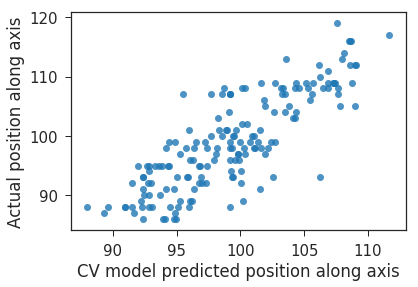

model cv score: r2 =  0.6853941520802075
running final model
final model fit r2 =  0.9848372912935882


/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



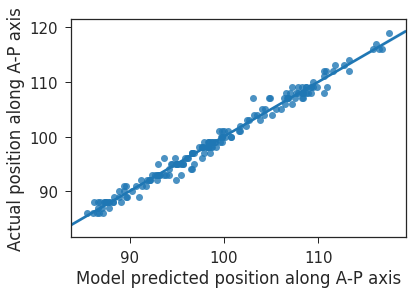

running sanity_check


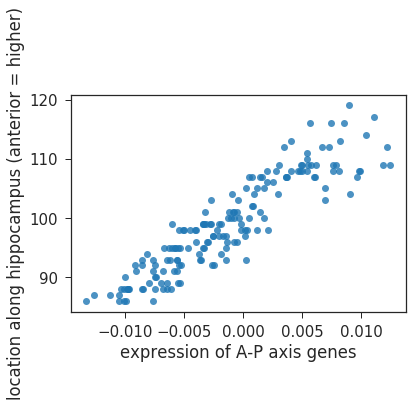

posterior and anterior 100 genes vs. y:  r2 = 0.8379163777193919, p = 2.783769465363898e-68 




In [116]:
# testing weighted averages
pls_out = hap.PCA_LR_pipeline(xp.values.T,
                            (df.position_along_hipp_AP_axis), 
                          clf = PLSRegression(n_components=9),
                          pca=None,
                            cv_strategy='score', illustrative=True,
                           test_gene_num = [100],
                               sanity_check_style = 'model')

Compare betas between LASSO-PCR and PCLR

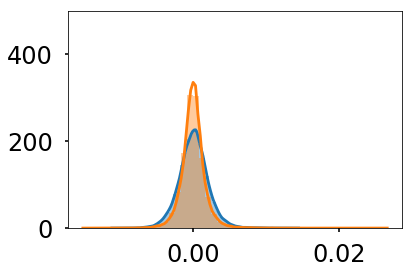

In [158]:
plt.close()
sns.distplot(pls_out['betas'])
sns.distplot(pcalr_out_NEW2['betas'])
plt.ylim(0,500)
plt.show()

In [160]:

jnk = pandas.DataFrame(index = range(len(pls_out['betas'])), columns = ['pls','lpcr'])
jnk.loc[:,'pls'] = pls_out['betas']
jnk.loc[:,'lpcr'] =  pcalr_out_NEW2['betas']
jnk.loc[:,'gene'] = probes.loc[:,'gene_symbol'].values

In [186]:
jnk.sort_values('pls',ascending=False).head(20)

,pls,lpcr,gene
23274,0.013777,0.016976,RSPH9
40112,0.012621,0.011282,NR2F2
2781,0.012260,0.013176,KCNG1
40987,0.012194,0.011192,NR2F2
35503,0.011922,0.011182,NR2F2
14245,0.011755,0.013917,SYTL2
35268,0.011522,0.006943,CADM1
20529,0.011215,0.014526,LYPD1
35836,0.011177,0.008229,OBFC2A
51984,0.011109,0.012813,A_23_P213527


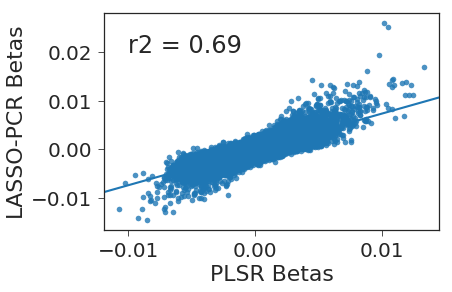

In [1028]:
plt.close()
sns.regplot(pls_mod.coef_[:,0], pcalr_out_NEW2['betas'])
plt.ylabel('LASSO-PCR Betas')
plt.xlabel('PLSR Betas')
r2 = stats.pearsonr(pls_mod.coef_[:,0], pcalr_out_NEW2['betas'])[0]**2
plt.text(-0.01, 0.02,'r2 = %s'%(float('%.2g' % r2)), fontsize=24)
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/PLS_comp.pdf', bbox_inches='tight')
plt.show()

Compare the normality of the residuals of the two models

In [174]:
fit_mod = pcalr_out_NEW2['final_model']
pred = fit_mod.predict(pcalr_out_NEW2['pca_object'].transform(xp.values.T))
resid = pred - df.position_along_hipp_AP_axis.values

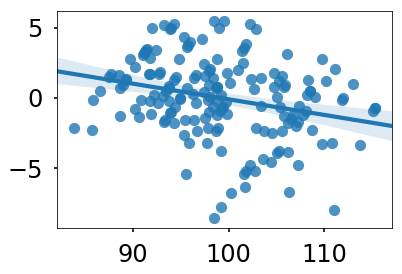

In [175]:
# Lasso-PCR
plt.close()
sns.regplot(pred, resid)
plt.show()

In [181]:
fit_mod = pls_out['final_model']
pred = fit_mod.predict(xp.values.T)[:,0]
resid = pred - df.position_along_hipp_AP_axis.values

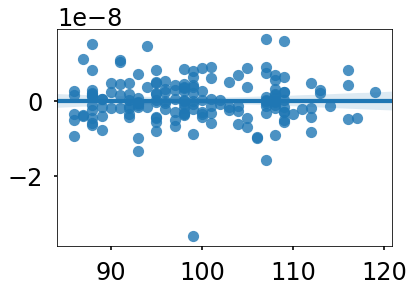

In [182]:
# PLSR
plt.close()
sns.regplot(pred, resid)
plt.show()

Do 10 runs of 10-fold CV

In [1016]:
clf = PLSRegression(n_components=9)
cv=10
cv_strategy=10
y = df.position_along_hipp_AP_axis
score = []
preds = np.zeros((cv_strategy,len(y)))
for i in range(cv_strategy):
    sel = model_selection.KFold(n_splits=cv, shuffle=True)
    predicted = model_selection.cross_val_predict(clf, xp.T, y=y, cv=sel)
    preds[i,:] = predicted[:,0]
    score.append(stats.pearsonr(predicted[:,0], y)[0]**2)
    print('completed iteration',i+1)
score


completed iteration 1
completed iteration 2
completed iteration 3
completed iteration 4
completed iteration 5
completed iteration 6
completed iteration 7
completed iteration 8
completed iteration 9
completed iteration 10


[0.72330624879038807,
 0.75589543929583103,
 0.75213202747701757,
 0.75207999653861468,
 0.75045163352351929,
 0.75253282291252688,
 0.72751655788284075,
 0.74355806289586279,
 0.7533459649039187,
 0.74219444856188121]

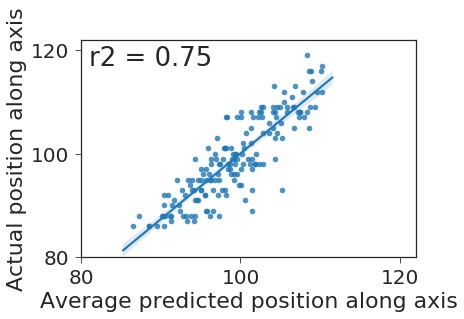

In [1018]:
plt.close()
sns.set_context('paper', font_scale=2.5)
sns.set_style('ticks')
sns.regplot(preds.mean(0), y, fit_reg=True)
plt.xlim(80,122)
plt.ylim(80,122)
plt.xticks(range(80,121,20))
plt.yticks(range(80,121,20))
plt.xlabel('Average predicted position along axis')
plt.ylabel('Actual position along axis')
r2 = np.float16(stats.pearsonr(preds.mean(0), y)[0]**2)
plt.text(81, 117,'r2 = %s'%(float('%.2g' % r2)), fontsize=26)
#plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/PLS_model.pdf', 
#            bbox_inches='tight')
plt.show()


In [956]:
pls_mod = PLSRegression(n_components=9).fit(xp.T, df.position_along_hipp_AP_axis)

Which genes are in the top 100 of the sets?
# THIS NEEDS TO BE MOVED

In [984]:
pls_beta = pandas.concat([pandas.Series(pls_mod.coef_[:,0]), probes.gene_symbol], axis=1)
pls_beta.sort_values(0,ascending=False)
pls_t50 = pls_beta.sort_values(0,ascending=False).head(50).index.tolist()
pls_b50 = pls_beta.sort_values(0,ascending=False).head(50).index.tolist()
pls_top100 = pls_t50 + pls_b50
print('n in gene set 1', len([x for x in pls_top100 if x in top_100.index]))
print('n in gene set 1 + 2', len([x for x in pls_top100 if x in top_600.index]))
print('n in gene set 1 + 2 + 3', len([x for x in pls_top100 if x in top_2700.index]))

n in gene set 1 50
n in gene set 1 + 2 92
n in gene set 1 + 2 + 3 100


In [995]:
pls_beta = pls_beta.sort_values(0,ascending=False)
pls_beta.loc[:,'pls_rank'] = range(len(pls_beta))
pls_beta = pls_beta.sort_values(0,ascending=True)
pls_beta.loc[:,'inv_pls_rank'] = range(len(pls_beta))

In [1035]:
pls_beta.columns = ['beta'] + pls_beta.columns[1:].tolist()
pls_beta.loc[pls_top100,['beta','gene_symbol']
            ].to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/Table_S4_PLS.csv')

# MAE stuff

In [1135]:
from sklearn.metrics import mean_absolute_error
for col in df.columns[-6:]:
    mae = mean_absolute_error(y_pred=df[col].values, y_true=df.position_along_hipp_AP_axis.values)
    print('%s: %s'%(col,mae))

All 58k: 2.17167002428
Set 1: 1.83934160541
Set 2: 2.38603721566
Set 1,2: 2.2042331308
Set 3: 1.85440130548
Set 1,2,3: 1.46009297804
